## Библиотеки, параметры, константы задачи

In [1]:
from applications.poly_features_environment import PolyFeaturesEnv
import torch
import models
import numpy as np
from common.fstream import read_tensor, read_matrix, rescale_array, read_mc_tensor

PATH_BASE = "/home/amedvedev/projects/python/DenoisingCNN"
NAME_DATASET = "gcg19"
env = PolyFeaturesEnv(name_model="uvych_tensor_denoiser_7_(scaled)", name_dataset=NAME_DATASET, path_base=PATH_BASE,
                      device_name="cuda")


## Загрузка данных

In [2]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(32, 80, 80), feature_name="Uvych2_re_noised.tensor", mapper=lambda path: read_mc_tensor(path, (None, (0, 1))), transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re.xls", mapper=lambda path: read_tensor(path), transform=None
    ) \

print(env.train_count, env.val_count)

27 16loading progress: |██████████████████████████████████████████████----| 93.8% Complete | 


In [ ]:
env.clear_features_and_targets()
env \
    .set_batch_size(
        train_batch_size=32, val_batch_size=4
    ) \
    .load_feature(
        shape=(8, 80, 80), feature_name="Uvych2_re_noised.tensor", mapper=lambda path: read_mc_tensor(path), transform=None
    ) \
    .set_target(
        shape=(1, 80, 80), target_name="Uvych2_re.xls", mapper=lambda path: read_matrix(path), transform=None
    ) \

print(env.train_count, env.val_count)

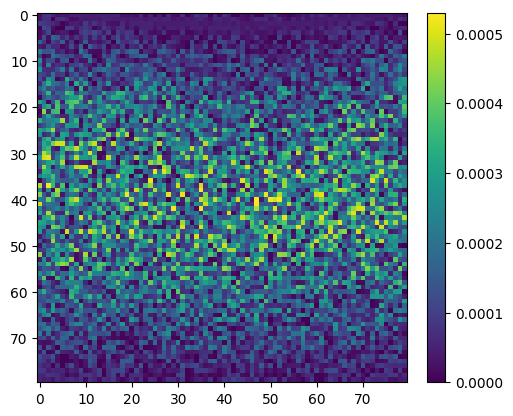

In [3]:
import matplotlib.pyplot as plt
im = plt.imshow(np.abs(env.train_features_loaders[0][0][0][0].cpu().detach().numpy() - env.train_target_loader[0][0][0].cpu().detach().numpy()))
plt.colorbar(im, orientation='vertical', fraction=0.046, pad=0.04)

## Модели

### Новая локальная модель

In [5]:
env.set_name_model("uvych_tensor_denoiser_3_(re)")

In [4]:
env.model = models.autoencoders.UnetAutoencoder.UNetAuto(num_channels=8, num_out_channels=1).to(env.device)

In [6]:
env.model = models.autoencoders.ConvAutoencoderLumaRelu(in_channels=32, out_channels=1).to(env.device)

In [5]:
env.model

UNetAuto(
  (conv_block1): WNetDownConvBlock(
    (layers): Sequential(
      (0): Conv2d(8, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReplicationPad2d((1, 1, 1, 1))
      (4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (7): ReplicationPad2d((1, 1, 1, 1))
    )
    (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): WNetDownConvBlock(
    (layers): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
      (1): ReLU()
      (2): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (3): ReplicationPad2d((1, 1, 1, 1))
      (4): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
      (5): ReLU()
      (6): BatchNorm2d(128, eps=1e-05, momentum=0.1

### Импорт претренерованной модели

In [5]:
env.load_model(model_type="pt")

## Визуализация батча валидационного датасета

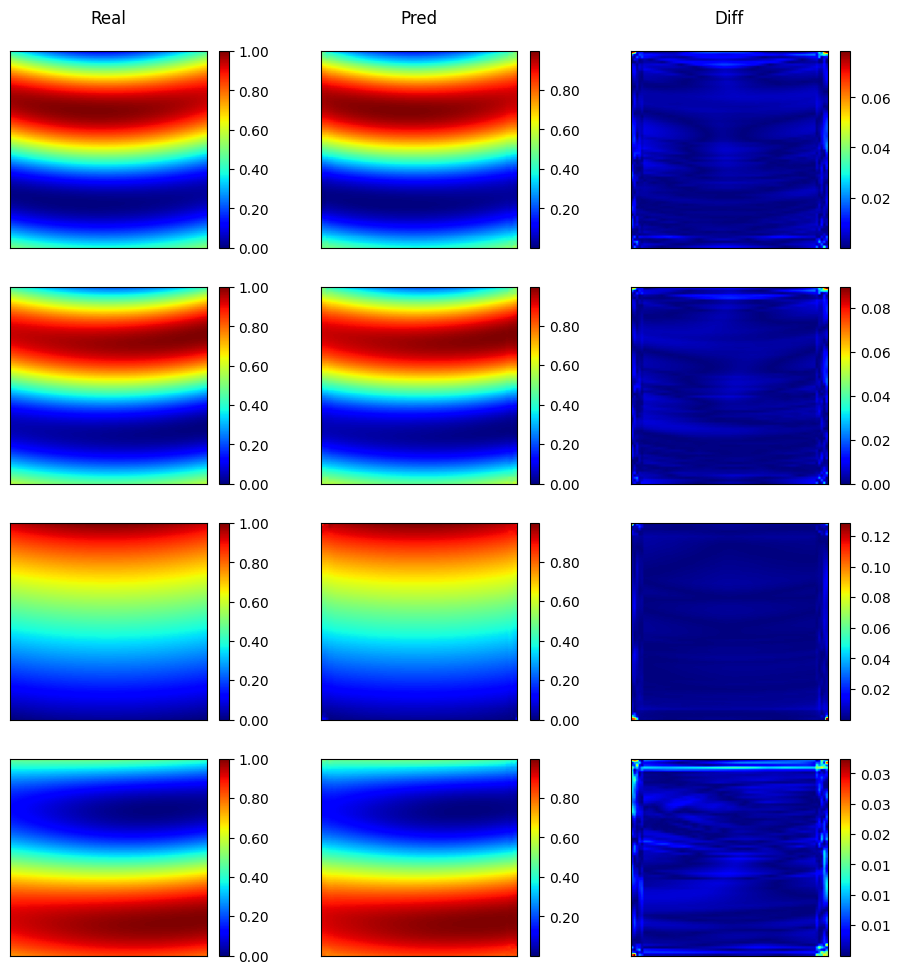

In [52]:
env.plot_batch(concrete=5, figsize=(10, 10), format="%.2f", wspace=0.0, hspace=0.2)


## Численные значения отклонений

In [50]:
def test():
    losses = []
    errors = []
    init_errors = []
    losses_dataset = []
    with torch.no_grad():
    
        for row in zip(*env.val_features_loaders + [env.val_target_loader]):
            data_features = list(row)
            data_target = data_features.pop()
            outputs = env.model(*data_features) #* 65.
            
            for ex_id in range(env.val_batch_size):
                
                for j in range(8):
                    losses_dataset_step = torch.mean(torch.abs(data_features[0][ex_id][j] - data_target[ex_id])).detach().tolist()
                    losses_dataset.append(losses_dataset_step)
                    
                    init_error = torch.mean(torch.abs(data_features[0][ex_id][j] - data_target[ex_id]) / data_target[ex_id])
                    init_errors.append(init_error.detach().tolist())
                
                loss = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]))
                losses.append(loss.detach().tolist())
                # print(data_target[ex_id].size())
                
                
                error = torch.mean(torch.abs(outputs[ex_id] - data_target[ex_id]) / data_target[ex_id])
                errors.append(error.detach().tolist())
                #print(outputs, data_target)
                
    print("Начальное среднее отклонение по значениям:", sum(losses_dataset) / len(losses_dataset))
    print("Текущее среднее отклонение по значениям:", sum(losses) / len(losses))
    
    print()
    print("Начальное максимальное отклонение по значениям:", max(losses_dataset))
    print("Текущее максимальное отклонение по значениям в векторе:", max(losses))
    
    print()
    print("Начальная средняя относительная ошибка:", sum(init_errors) / len(init_errors))
    print("Текущая средняя относительная ошибка:", sum(errors) / len(errors))
    print()
    print("Начальная максимальная относительная ошибка:", max(init_errors))
    print("Текущая максимальная относительная ошибка:", max(errors))
test()

Начальное среднее отклонение по значениям: 0.0001932552863621595
Текущее среднее отклонение по значениям: 0.00207850066908577

Начальное максимальное отклонение по значениям: 0.0009536084835417569
Текущее максимальное отклонение по значениям в векторе: 0.004535190295428038

Начальная средняя относительная ошибка: nan
Текущая средняя относительная ошибка: nan

Начальная максимальная относительная ошибка: nan
Текущая максимальная относительная ошибка: inf


## Training

In [9]:
from common.losses import MseCoeffLoss, L1CoeffLoss

In [24]:
env.set_name_model("uvych_tensor_denoiser_2")

In [9]:
opt = torch.optim.Adam(env.model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(opt, patience=4)


In [46]:
env.train(50, step_saving=False, step_plotting=False,
          optimizer=opt, scheduler=None, 
          criterion=torch.nn.SmoothL1Loss(reduction="sum"), callbacks=[lambda: scheduler.step(env.test_losses[-1])])

# reduce="none", reduction="none"

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 1 	Training Loss: 1.890887 	Validating Loss: 0.236043 	Time: 0.17 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 2 	Training Loss: 1.874310 	Validating Loss: 0.233477 	Time: 0.17 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 3 	Training Loss: 1.855370 	Validating Loss: 0.231365 	Time: 0.17 m

Training progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Validating progress: |██████████████████████████████████████████████████| 100.0% Complete | 

Epoch: 4 	Training Loss: 1.8

## Сохранение модели

In [53]:
env.save(onnx=False, pth=False)

## Loss visualisation

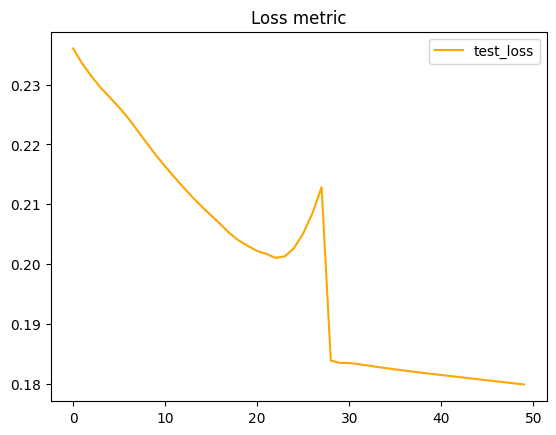

In [49]:
env.show_metrics(n_last=50, train=False, val=True)

## Clear memory

In [27]:
import gc
gc.collect()


42269

In [9]:
env.model.cpu()
del env.model

torch.cuda.empty_cache()